##### Copyright 2020 Qiyang Hu

In [0]:
#@title Licensed under MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/idre_learning_deep_learning/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Import Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image
import zipfile

%matplotlib inline

print(torch.__version__)

1.4.0


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Mount Google Drive
For save/load the model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Download Data from Kaggle

In [6]:
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [7]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [8]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content

 98% 265M/271M [00:04<00:00, 54.3MB/s]
100% 271M/271M [00:04<00:00, 58.8MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 120MB/s]
 99% 536M/544M [00:08<00:00, 83.8MB/s]
100% 544M/544M [00:08<00:00, 67.8MB/s]


In [0]:
with zipfile.ZipFile("train.zip","r") as zip_ref:
    zip_ref.extractall("/content/")
with zipfile.ZipFile("test.zip","r") as zip_ref:
    zip_ref.extractall("/content/")

# Import Image Training Data

In [0]:
train_orig_dir = '/content/train'
train_orig_files = os.listdir(train_orig_dir)

# prepend the absolute path to image files
def train_path(p): return f"/content/train/{p}"
train_orig_files = list(map(train_path, train_orig_files))

**NOTES:**

1.   We just simply split the training data to use 2/3 part as training set and the last 1/3 as validation set to demostrate the process of training and validation. 
2.   Since the dataset is well balanced, we don't need to make cross validation for the training set for model selection. 
3.   For problems which need cross validation (e.g. imbalanced data, etc.), we can use [skorch](https://github.com/skorch-dev/skorch)'s [CVSplit](https://skorch.readthedocs.io/en/latest/user/dataset.html?highlight=fold#cvsplit) function. Or just use sklearn's [StratifiedKFold](https://scikit-learn.org/stable/modules/cross_validation.html) function to do the loop for model selection. Sample code can be like below:

```
from sklearn.model_selection import StratifiedKFold
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model ...
	# Do epoch loop ...
    scores = 0.0
	  # Do loop from dataloader ...
	  # train the model ...
	  scores += loss_fn(pred, label)
	cvscores.append(scores * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
```

In [11]:
min_index_validation = int(len(train_orig_files)/3)*2 # using 1/3 of training data as validation data
train_files = train_orig_files[:min_index_validation]
valid_files = train_orig_files[min_index_validation:]
print(min_index_validation)

16666


In [0]:
class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform
        
    def __len__(self): return self.len
    
    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)

In [0]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

In [14]:
train_ds = CatDogDataset(train_files, transform)
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=4)
len(train_ds), len(train_dl)

(16666, 167)

In [15]:
valid_ds = CatDogDataset(valid_files, transform)
valid_dl = DataLoader(valid_ds, batch_size=100, shuffle=True, num_workers=4)
len(valid_ds), len(valid_dl)

(8334, 84)

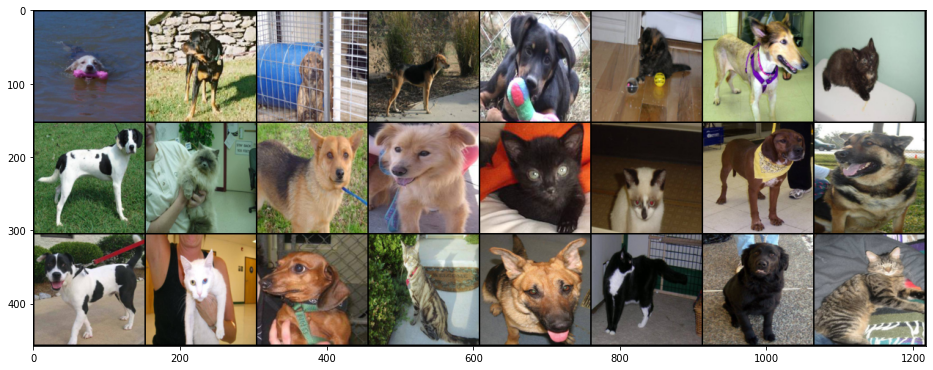

In [16]:
samples, labels = iter(valid_dl).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

# Create the Model

In [0]:
class CatAndDogNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3))
        self.fc1 = nn.Linear(in_features= 128 * 7 * 7, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
          
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2)

        X = X.view(-1, self.num_flat_features(X))
        X = F.relu(self.fc1(X))

        # Different from Keras, pytorch's nn.CrossEntropyLoss does not need a nn.Softmax(dim=1) in latest layer, because the Cross Entropy loss funtion already include softmax function.
        # X = F.softmax(self.fc3(X),dim=0)
        X = self.fc2(X)

        return X

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:       # Get the products
            num_features *= s
        return num_features

In [18]:
model = CatAndDogNet().to(device)
print(model)

CatAndDogNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


# Train the model

In [0]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [0]:
losses = []
accuracies = []
val_losses = []
val_accuracies = []
EPOCHS = 50
start = time.time()

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0
    for X, y in train_dl:
        # get the inputs
        X = X.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        
        # print statistics
        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)
        
    epoch_accuracy = epoch_accuracy/len(train_dl)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    losses.append(epoch_loss)
    print("\nEpoch: {}, train loss: {:.4f}, train accracy: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))


    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_accuracy = 0
        for val_X, val_y in valid_dl:
            val_X = val_X.to(device)
            val_y = val_y.to(device)
            val_preds = model(val_X)
            val_loss = loss_fn(val_preds, val_y)

            val_epoch_loss += val_loss            
            val_accuracy = ((val_preds.argmax(dim=1) == val_y).float().mean())
            val_epoch_accuracy += val_accuracy
        val_epoch_accuracy = val_epoch_accuracy/len(valid_dl)
        val_accuracies.append(val_epoch_accuracy)
        val_epoch_loss = val_epoch_loss / len(valid_dl)
        val_losses.append(val_epoch_loss)
        print("Epoch: {}, valid loss: {:.4f}, valid accracy: {:.4f}, time: {}\n".format(epoch, val_epoch_loss, val_epoch_accuracy, time.time() - start))

print('Finished Training')

.......................................................................................................................................................................
Epoch: 0, train loss: 0.6694, train accracy: 0.5679, time: 62.7431640625
Epoch: 0, valid loss: 0.6340, valid accracy: 0.6372, time: 92.13692855834961

.......................................................................................................................................................................
Epoch: 1, train loss: 0.5949, train accracy: 0.6788, time: 154.08127284049988
Epoch: 1, valid loss: 0.5474, valid accracy: 0.7150, time: 182.55330204963684

.......................................................................................................................................................................
Epoch: 2, train loss: 0.5334, train accracy: 0.7293, time: 243.05717635154724
Epoch: 2, valid loss: 0.4978, valid accracy: 0.7544, time: 271.38267183303833

...............................

## Visualize the training & validation results

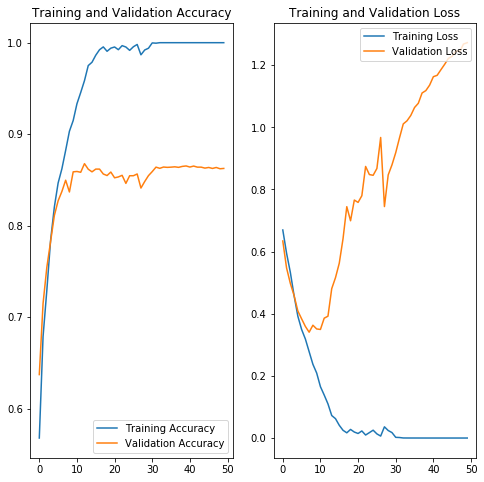

In [0]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

## Save the model

In [0]:
t = time.time()
savedmodel_dir = "/content/drive/My Drive/saved_model/dogcats_pytorch/plain/{}".format(int(t))
if not os.path.isdir(savedmodel_dir):
    os.makedirs(savedmodel_dir)
filename = 'ckpt_plain_catdog.pth'
filename_pth = os.path.join(savedmodel_dir, filename)
print(filename_pth)

/content/drive/My Drive/saved_model/dogcats_pytorch/plain/1574373208/ckpt_plain_catdog.pth


In [0]:
torch.save(model.state_dict(), filename_pth)

## Load the model

In [20]:
filename_pth = '/content/drive/My Drive/saved_model/dogcats_pytorch/plain/1574373208/ckpt_plain_catdog.pth'
model = CatAndDogNet().to(device)
model.load_state_dict(torch.load(filename_pth))
#model.eval()

<All keys matched successfully>

# Predict the model

## Prepare the test data

In [0]:
test_dir = '/content/test'
test_files = os.listdir(test_dir)

def test_path(p): return f"/content/test/{p}"
test_files = list(map(test_path, test_files))

In [0]:
class TestCatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform
        
    def __len__(self): return self.len
    
    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        fileid = path.split('/')[-1].split('.')[0]
        return (image, fileid)

In [23]:
test_ds = TestCatDogDataset(test_files, transform)
test_dl = DataLoader(test_ds, batch_size=100)
len(test_ds), len(test_dl)

(12500, 125)

## Preditic the test dataset

In [0]:
model.eval()
fn_list = []
pred_list = []
with torch.no_grad():
    for X, fileid in test_dl:
        X = X.to(device)
        preds = model(X)
        fn_list += fileid
        pred_list += F.softmax(preds, dim=1)[:,1].tolist()
        
submission = pd.DataFrame({"id":fn_list, "label":pred_list})

In [25]:
submission.head()

,id,label
0,2107,1.000000e+00
1,8959,9.999869e-01
2,9741,3.545136e-20
3,9624,1.000000e+00
4,285,1.517077e-09


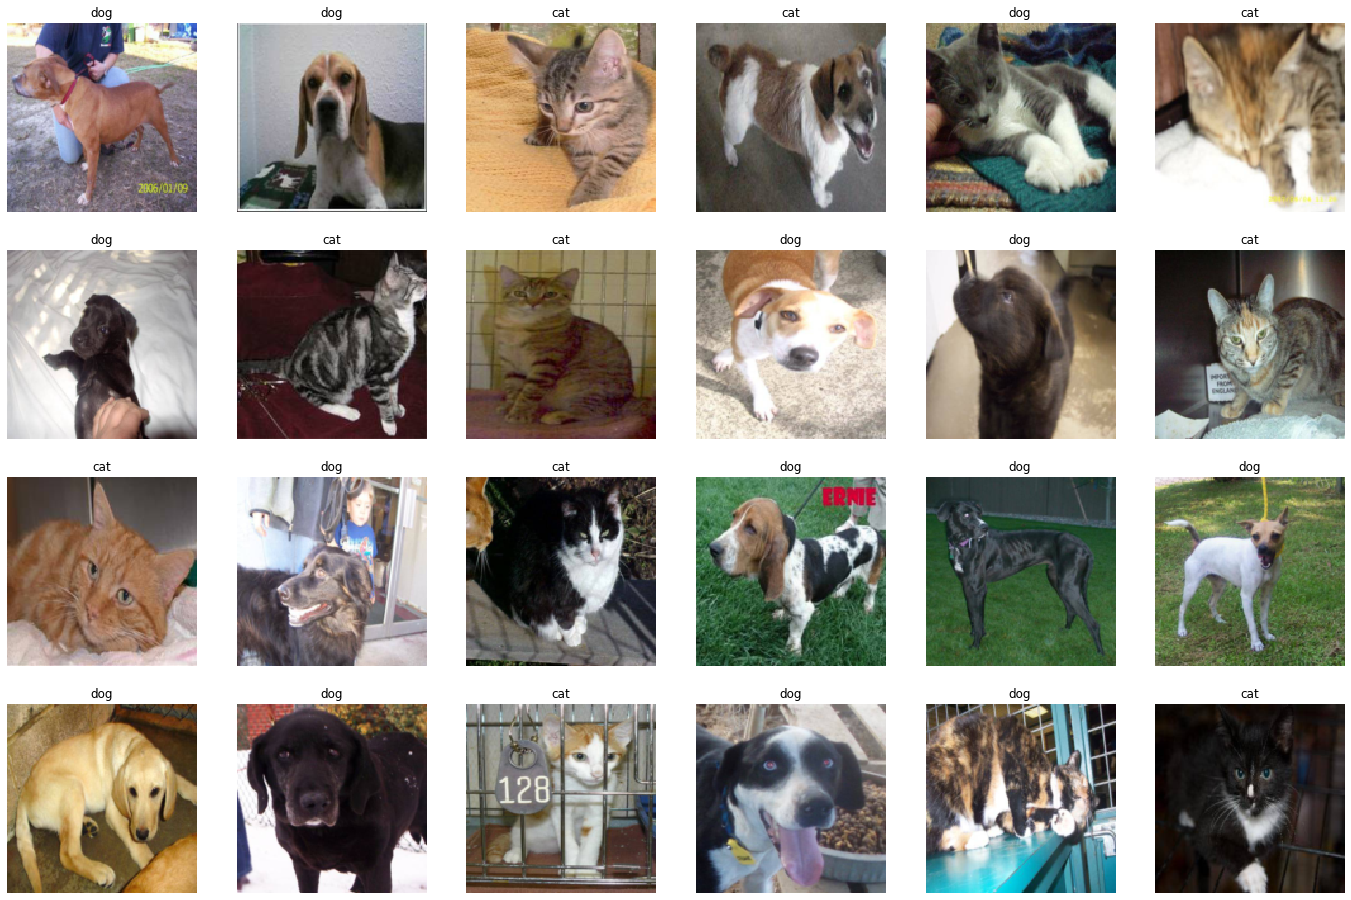

In [0]:
samples, _ = iter(test_dl).next()
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = submission[:24]['label']
for num, sample in enumerate(samples[:24]):
    category = "dog" if submission.iloc[num,:]['label'] >= 0.5 else "cat"
    plt.subplot(4,6,num+1)
    plt.title(category)
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

# Submission to Kaggle

NOTE: Before submission, you need to re-run the notebook using the whole set of training files without validation set to get a better result.

In [0]:
submission.to_csv('preds.csv', index=False)

In [0]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f preds.csv -m "My first pytorch submission without data augmentation"